In [2]:
%load_ext autoreload
%env TFDS_DATA_DIR=/Users/paul/scratch/tensorflow_datasets

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.methods import MLS
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import DataHandler

def normalize(x):
    return x/255


env: TFDS_DATA_DIR=/Users/paul/scratch/tensorflow_datasets


2023-02-03 11:58:32.184910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paul/.virtualenvs/tfmetal/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [4]:

model = tf.keras.models.load_model("../saved_models/mnist_model")

Metal device set to: AMD Radeon Pro 5500M

systemMemory: 64.00 GB
maxCacheSize: 3.99 GB



In [5]:


data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]

## Maximum Logit Score
(A good classifier is all you need ?)

Example of method that does not need ID data to compute statistics to compare against

In [6]:
%autoreload 2

data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]


x_test = data_handler.merge_tfds(x_id, x_ood, shuffle=True).batch(100)

2023-02-03 12:03:26.240465: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:

%autoreload 2

oodmodel = MLS()
oodmodel.fit(model)
scores = oodmodel.score(x_test)

Score visualization

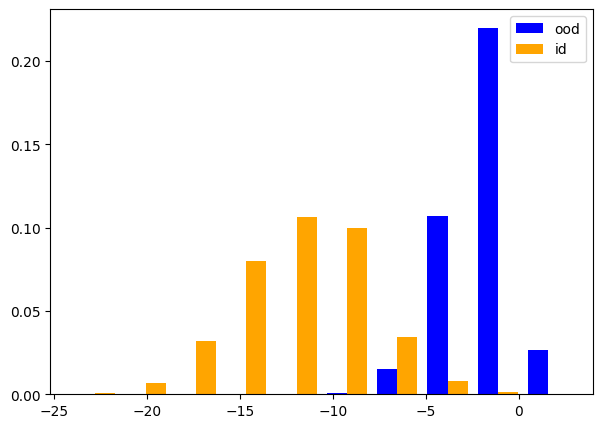

In [8]:
%autoreload 2

plt.figure(figsize=(7,5))

scores_id = oodmodel.score(x_id.batch(100))
scores_ood = oodmodel.score(x_ood.batch(100))
plt.hist((scores_ood, scores_id), bins=10, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

## Deep KNN
Example of method that needs ID data to compute statistics to compare against

In [9]:
data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]
x_train = ds1["train"]


x_test = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000), shuffle='True').batch(100)


2023-02-03 12:03:42.975251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
%autoreload 2
oodmodel = DKNN()
oodmodel.fit(model, x_train.take(10000).batch(100))
scores = oodmodel.score(x_test)

2023-02-03 12:07:05.733856: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-03 12:07:06.066952: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-03 12:07:06.172009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

Score visualization

2023-02-03 12:08:02.872089: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-03 12:08:03.209318: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


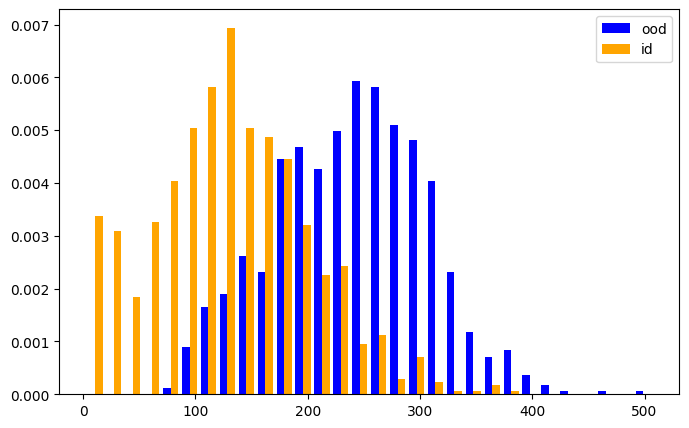

In [15]:
%autoreload 2
plt.figure(figsize=(8,5))


#x_id, y_id = data_handler.convert_to_numpy(x_id)
#x_ood, y_ood = data_handler.convert_to_numpy(x_ood)
scores_id = oodmodel.score(x_id.take(1000).batch(100))
scores_ood = oodmodel.score(x_ood.take(1000).batch(100))
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

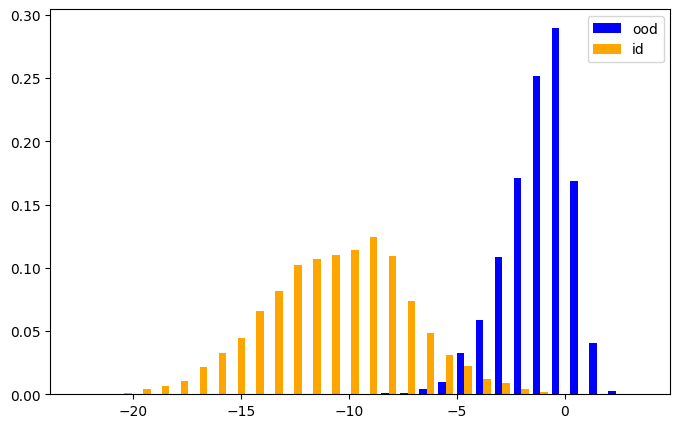

In [20]:
%autoreload 2
from oodeel.methods import ODIN

data_handler = DataHandler()
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)
x_id = ds1["test"]
x_ood = ds2["test"]
x_train = ds1["train"]


oodmodel = ODIN()
oodmodel.fit(model)



plt.figure(figsize=(8,5))
#x_idn, y_id = data_handler.convert_to_numpy(x_id)
#x_oodn, y_ood = data_handler.convert_to_numpy(x_ood)
scores_id = oodmodel.score(x_id.batch(100))
scores_ood = oodmodel.score(x_ood.batch(100))
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()